This journal will calculate an Air burden Index to evaluate the burden caused by pollution on the surrounding environments.

ABI = z(E)*wd + z(PWE)*wp + z(S)*ws

where:
 z = z-score normalization
 z(E) = Direct pollution exposure (from pollutionJournal calculations)
 wd = 0.5 => Weighting of direct exposure. 
 z(PWE) = Population weighted exposure. Places higher significance on pollution of populated areas
 wp = 0.3 => Weighting for the z(PWE) parameter
 z(S) = 0.2 => Sensitivity parameter, to scale index score by relative vulnerability a population in that area.
 ws = weighting for population sensitivity.

Weighting values and rationale:
 wd: 0.5 - Interpreted based on recommendations from The Institute for Health and Metrics + The World Health Organization. See citations below.
 wp: 0.3 - Interpreted based on recommendations from The Institute for Health and Metrics + The World Health Organization. See citations below.
 ws: 0.2 - Based on interpretation of Flanagan, Barry E. et al. (2011)

 World Health Organization. (2021). WHO global air quality guidelines: Particulate matter (PM₂.₅ and PM₁₀), ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide. Geneva: World Health Organization.

 Brauer, M. et al (2024). Global burden and strength of evidence for 88 risk factors in 204 countries and 811 subnational locations, 1990–2021: a systematic analysis for the Global Burden of Disease Study 2021. The Lancet, 403(10440), 2162–2203. doi: 10.1016/S0140-6736(24)00933-4

 NASA SEDAC / Yale-CIESIN (2022) Environmental Performance Index: Technical Documentation. Center for International Earth Science Information Network, Columbia University.

 Flanagan, Barry E. et al. (2011). A Social Vulnerability Index for Disaster Management. 8(1). 

 AI Usage Disclosure: Microsoft copilot was used for templating and syntax correction. The majority of the code was written manually based on previous experience with similar work.     

In [14]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [27]:
# Load the csv files for pollution data in the Peachtree Corners area

pollutionData = pd.read_csv('processedData/ec_2019_ptc_trimmed.csv')
populationData = pd.read_csv('processedData/populationData_PeachtreeCorners.csv')

# Calculate z-scores for both datasets
pollutionData['ec_zscore'] = (pollutionData['ec'] - pollutionData['ec'].mean()) / pollutionData['ec'].std()
populationData['population_zscore'] = (populationData['population'] - populationData['population'].mean()) / populationData['population'].std()

print("Pollution Data:\n")
print(pollutionData['ec_zscore'].describe())
print("\nPopulation Data:\n")
print(populationData['population_zscore'].describe())

Pollution Data:

count    8.702200e+04
mean     3.762475e-16
std      1.000000e+00
min     -2.217470e+00
25%     -6.543780e-01
50%     -1.737357e-01
75%      3.465663e-01
max      5.745008e+00
Name: ec_zscore, dtype: float64

Population Data:

count    1.174060e+05
mean    -2.323973e-17
std      1.000000e+00
min     -1.238303e+00
25%     -7.816922e-01
50%     -1.813633e-01
75%      5.602194e-01
max      6.973308e+00
Name: population_zscore, dtype: float64


In [28]:
from sklearn.neighbors import NearestNeighbors

# Clone the pollution data to use it as a base for nearest neighbor merging
mergedData = pollutionData.copy()
# Use pollutionData as the base, merge population data into it
pollutionCoords = pollutionData[['latitude', 'longitude']].to_numpy()
populationCoords = populationData[['latitude', 'longitude']].to_numpy()

# Fit NearestNeighbors on population coordinates
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(populationCoords)
distances, indices = nbrs.kneighbors(pollutionCoords)

# indices is a 2d array, we will use [:, 0] syntax to get the first column for indexing
mergedData['population'] = populationData.iloc[indices[:,0]]['population'].values
mergedData['population_zscore'] = populationData.iloc[indices[:,0]]['population_zscore'].values

# Show the merged dataframe info and head
print(mergedData.info())
print(mergedData.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87022 entries, 0 to 87021
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   longitude          87022 non-null  float64
 1   latitude           87022 non-null  float64
 2   ec                 87022 non-null  float64
 3   ec_normalized      87022 non-null  float64
 4   ec_zscore          87022 non-null  float64
 5   population         87022 non-null  int64  
 6   population_zscore  87022 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 4.6 MB
None
   longitude   latitude        ec  ec_normalized  ec_zscore  population  \
0 -84.144453  34.051345  0.587143       0.154237  -0.989365         752   
1 -84.143886  34.051287  0.585369       0.152296  -1.004814         345   
2 -84.143320  34.051228  0.585541       0.152484  -1.003316         345   
3 -84.142754  34.051169  0.575837       0.141869  -1.087841         692   
4 -84.148492  34.051308  0.604

# Calculating Population Weighted Exposure

Ideally, this would use something like Ivy, D., Mulholland, J. A., & Russell, A. G. (2008). Development of ambient air quality population-weighted metrics for use in time-series health studies. Journal of the Air & Waste Management Association (1995), 58(5), 711–720. https://doi.org/10.3155/1047-3289.58.5.711

In the interest of limiting hackathon scope, here we will use population density per km^2, assuming 100m grid squares, times the pollution measurements

PWE = p/A * P

where:
  p = population in this grid square
  A = area of a grid square, in km^2
  P = pollution measurement for this grid square

In [32]:
# using the formula above
mergedData['pwe'] = mergedData['ec'] * mergedData['population']/(0.1*0.1)

# And the z score for this
mergedData['pwe_zscore'] = (mergedData['pwe'] - mergedData['pwe'].mean()) / mergedData['pwe'].std()

mergedData[['pwe', 'pwe_zscore']].describe()

,pwe,pwe_zscore
count,8.702200e+04,8.702200e+04
mean,1.234684e+05,1.045132e-16
std,1.037230e+05,1.000000e+00
min,4.724681e+01,-1.189911e+00
25%,4.709801e+04,-7.362920e-01
50%,1.052966e+05,-1.751960e-01
75%,1.715211e+05,4.632787e-01
max,1.080447e+06,9.226292e+00


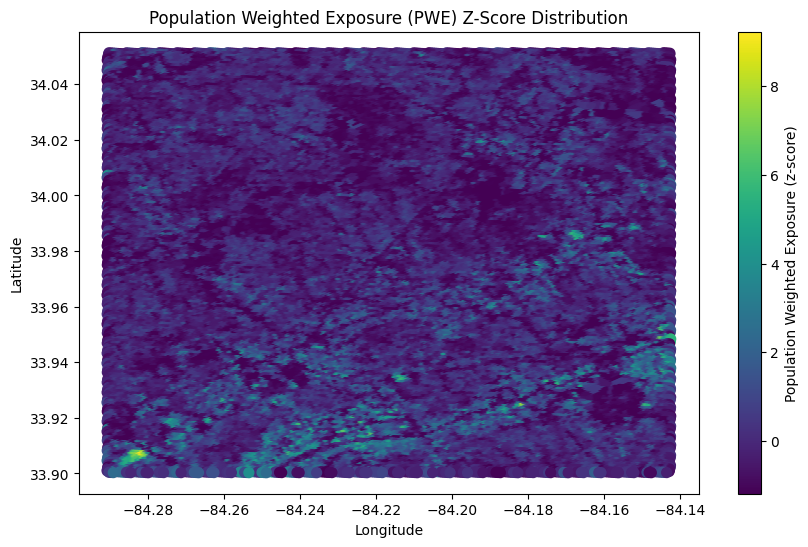

In [33]:
# Let's visualize this
plt.figure(figsize=(10, 6))
plt.scatter(mergedData['longitude'], mergedData['latitude'], c=mergedData['pwe_zscore'], cmap='viridis', s=50)
plt.colorbar(label='Population Weighted Exposure (z-score)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Population Weighted Exposure (PWE) Z-Score Distribution')
plt.show() 

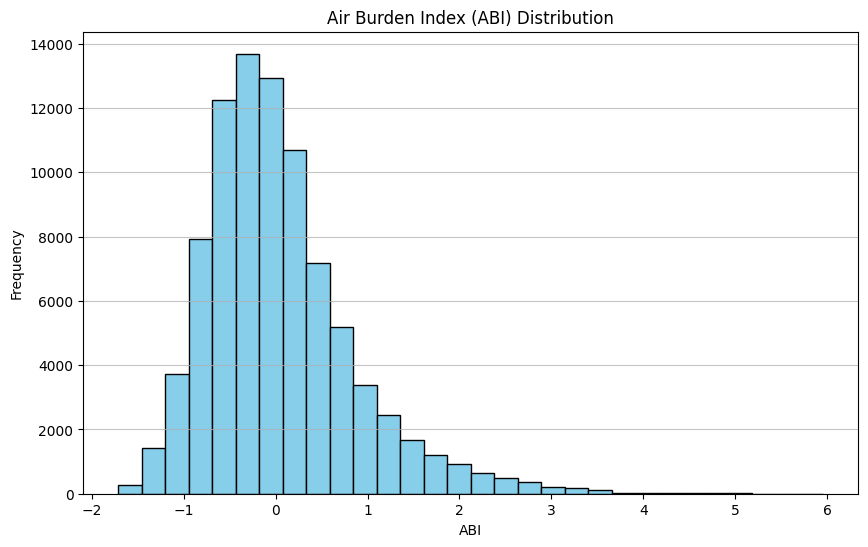

In [34]:
# Finally, we are ready to calculate the ABI
wd = 0.5
wp = 0.3
ws = 0.2
    
mergedData['abi'] = (wd * mergedData['ec_zscore'] + 
                     wp * mergedData['pwe_zscore'] + 
                     ws * mergedData['population_zscore'])

# Show the ABI distribution
plt.figure(figsize=(10, 6))
plt.hist(mergedData['abi'], bins=30, color='skyblue', edgecolor='black')
plt.title('Air Burden Index (ABI) Distribution')
plt.xlabel('ABI')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

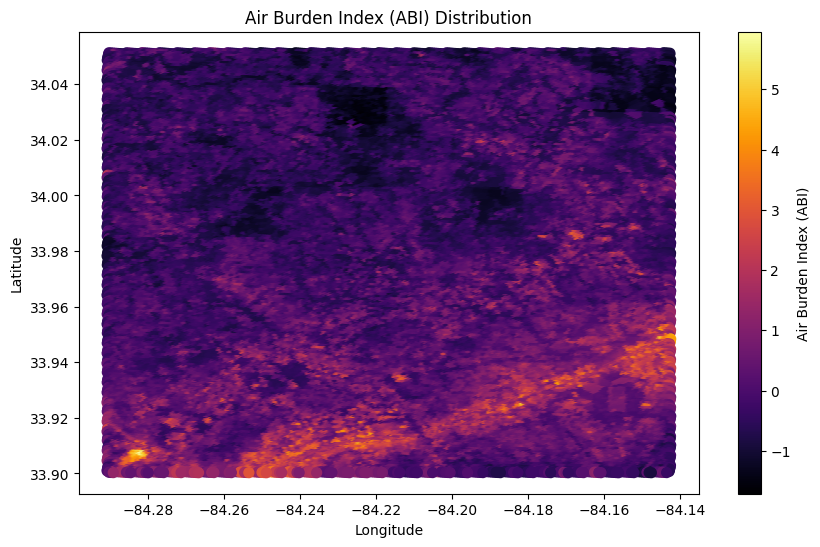

In [36]:
# Plot the ABI geographically
plt.figure(figsize=(10, 6))
plt.scatter(mergedData['longitude'], mergedData['latitude'], c=mergedData['abi'], cmap='inferno', s=50)
plt.colorbar(label='Air Burden Index (ABI)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Air Burden Index (ABI) Distribution')
plt.show()

In [40]:
# Add one more column - ABI rescaled to 0-1 for easier plotting
mergedData['abi_rescaled'] = (mergedData['abi'] - mergedData['abi'].min()) / (mergedData['abi'].max() - mergedData['abi'].min())

print(mergedData[['abi', 'abi_rescaled']].describe())

                abi  abi_rescaled
count  87022.000000  87022.000000
mean       0.036279      0.227983
std        0.804060      0.104892
min       -1.711342      0.000000
25%       -0.506688      0.157151
50%       -0.096707      0.210634
75%        0.401563      0.275635
max        5.954245      1.000000


In [42]:
# Export the final dataframe with ABI to a CSV file
mergedData.to_csv('processedData/air_burden_index.csv', index=False)
print("ABI data exported to 'processedData/air_burden_index.csv'")

ABI data exported to 'processedData/air_burden_index.csv'
